# Wind Downscaling

## Prerequisites

* Conda environment
* Get a Copernicus API key from: https://cds.climate.copernicus.eu/api-how-to
  * create a file at \$HOME/.cdsapirc with the required UID and key
* Create a .env file in the same folder as this notebook, and add the COSMO_USERNAME and COSMO_PASSWORD to connect to the UNI-BE server

## Install the required packages

In [1]:
from datetime import date
from pathlib import Path
import os

In [2]:
if Path('./setup.py').exists():
    !pip install -e .
else:
    !pip install -U git+https://github.com/OpheliaMiralles/WindDownscaling_EPFL_UNIBE.git

Obtaining file:///Users/Boubou/Documents/GitHub/WindDownscaling_EPFL_UNIBE
  Attempting uninstall: downscaling
    Found existing installation: downscaling 1.0
    Uninstalling downscaling-1.0:
      Successfully uninstalled downscaling-1.0
  Running setup.py develop for downscaling


In [3]:
!conda install -y -c conda-forge gdal tensorflow xarray numpy=1.19.5 pandas pysftp cdsapi elevation rasterio dask python-dotenv

Solving environment: done

# All requested packages already installed.



In [4]:
!pip install topo-descriptors

In [5]:
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import tensorflow as tf
import tensorflow.keras.callbacks as cb
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs Available: 0


## Set configuration

In [6]:
DATA_ROOT = Path('./data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
COSMO1_DATA_FOLDER = DATA_ROOT / 'COSMO1'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'

DATA_ROOT.mkdir(parents=True, exist_ok=True)
ERA5_DATA_FOLDER.mkdir(exist_ok=True)
COSMO1_DATA_FOLDER.mkdir(exist_ok=True)
DEM_DATA_FILE.parent.mkdir(exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)

In [7]:
ERA5_PREDICTORS_SURFACE = ('u10', 'v10', 'blh', 'fsr', 'sp', 'sshf',
                               'u100', 'v100')
ERA5_PREDICTORS_Z500 = ('d', 'z', 'u', 'v', 'w', 'vo')
TOPO_PREDICTORS = ('tpi_500', 'ridge_index_norm', 'ridge_index_dir',
                   'we_derivative', 'sn_derivative',
                   'slope', 'aspect')
HOMEMADE_PREDICTORS = ('e_plus', 'e_minus')
ALL_INPUTS = ['u10', 'v10', 'sp']+ list(HOMEMADE_PREDICTORS) + list(TOPO_PREDICTORS)#ERA5_PREDICTORS_SURFACE + TOPO_PREDICTORS
ALL_OUTPUTS = ['U_10M', 'V_10M']

In [8]:
# Start and end date for the data - should be in the 2016-2020 range
START_DATE = date(2016,4,1)
END_DATE = date(2017,4,1)
NUM_DAYS = (END_DATE-START_DATE).days + 1
# Number of consecutive images to form a sequence
SEQUENCE_LENGTH = 3
# Size of the high resolution image to be produced
IMG_SIZE = 128
# Number of noise channels to add to the image
NOISE_CHANNELS = 500
# Number of sequences per batch
BATCH_SIZE = 8
# Number of workers to run to process the data to create the batches
BATCH_WORKERS = 8
# Latent dimension for the autoencoder
USE_AUTOENCODER = True
AUTOENCODER_OUTPUT_FEATURES = 8

## Data Loading

In [9]:
from data.download_ERA5 import download_ERA5
download_ERA5(ERA5_DATA_FOLDER, START_DATE, END_DATE)
print('Done')

File 20160401_era5_surface_hourly already exists
File 20160402_era5_surface_hourly already exists
File 20160403_era5_surface_hourly already exists
File 20160404_era5_surface_hourly already exists
File 20160405_era5_surface_hourly already exists
File 20160406_era5_surface_hourly already exists
File 20160407_era5_surface_hourly already exists
File 20160408_era5_surface_hourly already exists
File 20160409_era5_surface_hourly already exists
File 20160410_era5_surface_hourly already exists
File 20160411_era5_surface_hourly already exists
File 20160412_era5_surface_hourly already exists
File 20160413_era5_surface_hourly already exists
File 20160414_era5_surface_hourly already exists
File 20160415_era5_surface_hourly already exists
File 20160416_era5_surface_hourly already exists
File 20160417_era5_surface_hourly already exists
File 20160418_era5_surface_hourly already exists
File 20160419_era5_surface_hourly already exists
File 20160420_era5_surface_hourly already exists
File 20160421_era5_s

In [10]:
if not DEM_DATA_FILE.exists():
    dest = str(DEM_DATA_FILE)
    !eio --product SRTM3 clip -o {dest} --bounds 5.27 45.4 11.03 48.16

In [11]:
from data.data_processing import process_topographic_variables_file
process_topographic_variables_file(DEM_DATA_FILE)

2021-10-07 11:34:13,285 INFO Loading /Users/Boubou/opt/anaconda3/envs/downscale_dev/lib/python3.9/site-packages/topo_descriptors/config/topo_descriptors.conf.
2021-10-07 11:34:13,286 INFO Loading configuration file: /Users/Boubou/opt/anaconda3/envs/downscale_dev/lib/python3.9/site-packages/topo_descriptors/config/topo_descriptors.conf


Already processed all topo files


In [12]:
username = os.getenv('COSMO_USERNAME')
password = os.getenv('COSMO_PASSWORD')
from data import download_COSMO1
download_COSMO1(username, password, COSMO1_DATA_FOLDER, START_DATE, END_DATE)

Finished downloading COSMO data


In [13]:
from data.data_processing import process_imgs
process_imgs(PROCESSED_DATA_FOLDER, ERA5_DATA_FOLDER, COSMO1_DATA_FOLDER, DEM_DATA_FILE.parent,
             surface_variables_included=ERA5_PREDICTORS_SURFACE,
             z500_variables_included=ERA5_PREDICTORS_Z500,
             topo_variables_included=TOPO_PREDICTORS,
             cosmo_variables_included=('U_10M', 'V_10M'),
             start_date=START_DATE, end_date=END_DATE)
print('Done')

Reading DEM data files
Inputs and outputs for date 20160401 have already been processed.
Inputs and outputs for date 20160402 have already been processed.
Inputs and outputs for date 20160403 have already been processed.
Inputs and outputs for date 20160404 have already been processed.
Inputs and outputs for date 20160405 have already been processed.
Inputs and outputs for date 20160406 have already been processed.
Inputs and outputs for date 20160407 have already been processed.
Inputs and outputs for date 20160408 have already been processed.
Inputs and outputs for date 20160409 have already been processed.
Inputs and outputs for date 20160410 have already been processed.
Inputs and outputs for date 20160411 have already been processed.
Inputs and outputs for date 20160412 have already been processed.
Inputs and outputs for date 20160413 have already been processed.
Inputs and outputs for date 20160414 have already been processed.
Inputs and outputs for date 20160415 have already bee

Inputs and outputs for date 20160803 have already been processed.
Inputs and outputs for date 20160804 have already been processed.
Inputs and outputs for date 20160805 have already been processed.
Inputs and outputs for date 20160806 have already been processed.
Inputs and outputs for date 20160807 have already been processed.
Inputs and outputs for date 20160808 have already been processed.
Inputs and outputs for date 20160809 have already been processed.
Inputs and outputs for date 20160810 have already been processed.
Inputs and outputs for date 20160811 have already been processed.
Inputs and outputs for date 20160812 have already been processed.
Inputs and outputs for date 20160813 have already been processed.
Inputs and outputs for date 20160814 have already been processed.
Inputs and outputs for date 20160815 have already been processed.
Inputs and outputs for date 20160816 have already been processed.
Inputs and outputs for date 20160817 have already been processed.
Inputs and

Inputs and outputs for date 20161207 have already been processed.
Inputs and outputs for date 20161208 have already been processed.
Inputs and outputs for date 20161209 have already been processed.
Inputs and outputs for date 20161210 have already been processed.
Inputs and outputs for date 20161211 have already been processed.
Inputs and outputs for date 20161212 have already been processed.
Inputs and outputs for date 20161213 have already been processed.
Inputs and outputs for date 20161214 have already been processed.
Inputs and outputs for date 20161215 have already been processed.
Inputs and outputs for date 20161216 have already been processed.
Inputs and outputs for date 20161217 have already been processed.
Inputs and outputs for date 20161218 have already been processed.
Inputs and outputs for date 20161219 have already been processed.
Inputs and outputs for date 20161220 have already been processed.
Inputs and outputs for date 20161221 have already been processed.
Inputs and

In [14]:
from data.data_generator import BatchGenerator, NaiveDecoder

batch_gen = BatchGenerator(path_to_data=PROCESSED_DATA_FOLDER, decoder=NaiveDecoder(normalize=True),
                           sequence_length=SEQUENCE_LENGTH,
                           patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                           input_variables=ALL_INPUTS,
                           output_variables= ALL_OUTPUTS,
                           start_date=START_DATE, end_date=END_DATE,
                           num_workers=BATCH_WORKERS)

inputs = []
outputs = []
with batch_gen as batch:
    for b in range(NUM_DAYS):
        print(f'Creating batch {b+1}/{NUM_DAYS}')
        x, y = next(batch)
        inputs.append(x)
        outputs.append(y)
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)
print(f"Inputs: {inputs.shape}")
print(f"Outputs: {outputs.shape}")

Creating batch 1/366


2021-10-07 11:35:08,587 WARNING multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


Creating batch 2/366
Creating batch 3/366
Creating batch 4/366
Creating batch 5/366
Creating batch 6/366
Creating batch 7/366
Creating batch 8/366
Creating batch 9/366
Creating batch 10/366
Creating batch 11/366
Creating batch 12/366
Creating batch 13/366
Creating batch 14/366
Creating batch 15/366
Creating batch 16/366
Creating batch 17/366
Creating batch 18/366
Creating batch 19/366
Creating batch 20/366
Creating batch 21/366
Creating batch 22/366
Creating batch 23/366
Creating batch 24/366
Creating batch 25/366
Creating batch 26/366
Creating batch 27/366
Creating batch 28/366
Creating batch 29/366
Creating batch 30/366
Creating batch 31/366
Creating batch 32/366
Creating batch 33/366
Creating batch 34/366
Creating batch 35/366
Creating batch 36/366
Creating batch 37/366
Creating batch 38/366
Creating batch 39/366
Creating batch 40/366
Creating batch 41/366
Creating batch 42/366
Creating batch 43/366
Creating batch 44/366
Creating batch 45/366
Creating batch 46/366
Creating batch 47/

Creating batch 363/366
Creating batch 364/366
Creating batch 365/366
Creating batch 366/366
Inputs: (2928, 3, 128, 128, 12)
Outputs: (2928, 3, 128, 128, 2)


In [15]:
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

if USE_AUTOENCODER:
    checkpoint_path_weights = Path('./checkpoints/autoencoder/weights.ckpt')
    if not checkpoint_path_weights.exists():
        print("No autoencoder weights found!")
    else:
        autoencoder = AutoEncoder(nb_channels_in=len(ALL_INPUTS), nb_channels_out=OUTPUT_FEATURES,
                           time_steps=SEQUENCE_LENGTH, img_size=IMG_SIZE)
        autoencoder.load_weights(checkpoint_path_weights)

        print("Reducing data dimension")
        inputs = autoencoder.encoder.predict(inputs)
        INPUT_CHANNELS = AUTOENCODER_OUTPUT_FEATURES

No autoencoder weights found!


In [16]:
#import sys
#if 'gan.train' in sys.modules:
 #   del sys.modules['gan.train']
#from gan import train

In [17]:
from gan import train, metrics
from gan.models import make_generator, make_discriminator
generator = make_generator(image_size=IMG_SIZE, in_channels=INPUT_CHANNELS,
                           noise_channels=NOISE_CHANNELS, out_channels=OUT_CHANNELS,
                           n_timesteps=SEQUENCE_LENGTH)
print(f"Generator: {generator.count_params():,} weights")

discriminator = make_discriminator(low_res_size=IMG_SIZE, high_res_size=IMG_SIZE, low_res_channels=INPUT_CHANNELS,
                                   high_res_channels=OUT_CHANNELS, n_timesteps=SEQUENCE_LENGTH)
print(f"Discriminator: {discriminator.count_params():,} weights")

Generator: 7,008,850 weights
Discriminator: 9,095,881 weights


In [18]:
from gan.ganbase import  GAN
from data.data_generator import FlexibleNoiseGenerator

noise_shape = (BATCH_SIZE, SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, NOISE_CHANNELS)
gan = GAN(generator, discriminator, noise_generator=FlexibleNoiseGenerator(noise_shape, std=1))

print(f"Total: {gan.generator.count_params() + gan.discriminator.count_params():,} weights")

Total: 16,104,731 weights


In [19]:
gan.compile(generator_optimizer=train.generator_optimizer(),
            generator_metrics= [tf.keras.metrics.RootMeanSquaredError(), metrics.LogSpectralDistance(),
                                metrics.WeightedRMSEForExtremes(), metrics.WindSpeedWeightedRMSE(),
                                metrics.SpatialKS()],
            discriminator_optimizer=train.discriminator_optimizer(),
                discriminator_loss=train.discriminator_loss,
           metrics = [metrics.discriminator_score_fake(), metrics.discriminator_score_real()])

In [20]:
checkpoint_path_weights = Path('./checkpoints/gan/weights-{epoch:02d}.ckpt')
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/gan')
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [21]:
%load_ext tensorboard
%tensorboard --logdir=logs/gan

In [22]:
import matplotlib.pyplot as plt
def show(images, dims=1, legends=None):
    fig, axes = plt.subplots(ncols= len(images), figsize=(10, 10))
    for ax, im in zip(axes, images):
        for i in range(dims):
            label = legends[i] if legends is not None else ''
            ax.imshow(im[0, :, :, i], cmap='jet')
            ax.set_title(label)
            ax.axis('off')
    plt.show()
    return fig

In [23]:
class ShowCallback(tf.keras.callbacks.Callback):
    def __init__(self, dims):
        self.dims = dims
        
    def on_epoch_begin(self, epoch, logs):
        noise = FlexibleNoiseGenerator(noise_shape)
        show(self.model.generator([inputs[:self.dims], noise(self.dims)]))

In [24]:
callbacks = [
    cb.TensorBoard(log_path, write_images=True, update_freq='batch', profile_batch=(2, 4)),
    cb.ProgbarLogger('steps'),
    cb.TerminateOnNaN(),
    ShowCallback(10),
    cb.ModelCheckpoint(str(checkpoint_path_weights), monitor='g_ws_weighted_rmse', mode='min',
                       save_best_only=False, period=8, save_weights_only=True),
]

2021-10-07 11:48:42,124 WARNING `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Epoch 1/100


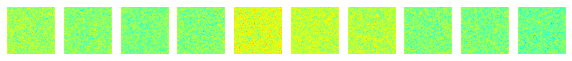

275/275 [==============================] - 5039s 18s/step - d_loss: -336.8058 - g_loss: 300.1338 - d_fake: 70.7210 - d_real: -103.6399 - g_root_mean_squared_error: 3.7879 - g_lsd: 11.6587 - g_extreme_rmse: 2.1058 - g_ws_weighted_rmse: 5.0853 - g_spatial_ks: 338.4067 - val_loss: 1455.5415 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 2/100


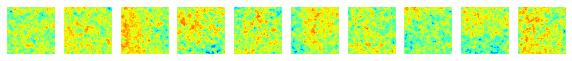

275/275 [==============================] - 5004s 18s/step - d_loss: -1609.9622 - g_loss: -2048.5973 - d_fake: -316.8164 - d_real: -1298.0510 - g_root_mean_squared_error: 3.8542 - g_lsd: 11.4627 - g_extreme_rmse: 2.0607 - g_ws_weighted_rmse: 4.9773 - g_spatial_ks: 348.2097 - val_loss: -30961.6094 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 3/100


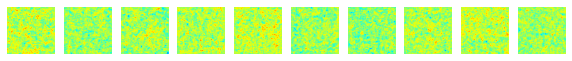

275/275 [==============================] - 5013s 18s/step - d_loss: -292.5862 - g_loss: -2345.2136 - d_fake: -5925.2727 - d_real: -6574.5641 - g_root_mean_squared_error: 3.7943 - g_lsd: 11.4064 - g_extreme_rmse: 2.0386 - g_ws_weighted_rmse: 4.9634 - g_spatial_ks: 347.9954 - val_loss: -47.0339 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 4/100


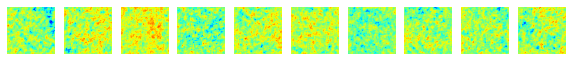

275/275 [==============================] - 5005s 18s/step - d_loss: -20.9951 - g_loss: 15.2947 - d_fake: 136.8909 - d_real: 97.3068 - g_root_mean_squared_error: 3.7267 - g_lsd: 11.2986 - g_extreme_rmse: 2.0268 - g_ws_weighted_rmse: 4.9411 - g_spatial_ks: 349.7743 - val_loss: 58.1438 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 5/100


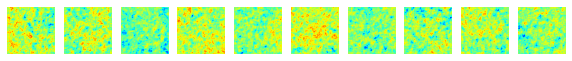

275/275 [==============================] - 5004s 18s/step - d_loss: -392.4109 - g_loss: 2023.0036 - d_fake: 937.1949 - d_real: 784.7375 - g_root_mean_squared_error: 3.6892 - g_lsd: 11.2281 - g_extreme_rmse: 2.0238 - g_ws_weighted_rmse: 4.9348 - g_spatial_ks: 350.2430 - val_loss: -34514.6289 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 6/100


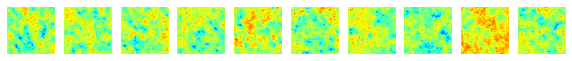

275/275 [==============================] - 5037s 18s/step - d_loss: -186.6309 - g_loss: 369.0787 - d_fake: 1314.2396 - d_real: 597.7827 - g_root_mean_squared_error: 3.6656 - g_lsd: 11.2113 - g_extreme_rmse: 2.0220 - g_ws_weighted_rmse: 4.9225 - g_spatial_ks: 348.9845 - val_loss: 0.2756 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 7/100


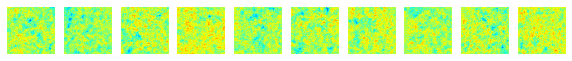

275/275 [==============================] - 5014s 18s/step - d_loss: -20.6866 - g_loss: 94.9367 - d_fake: 127.0784 - d_real: 108.1190 - g_root_mean_squared_error: 3.6154 - g_lsd: 11.2233 - g_extreme_rmse: 2.0157 - g_ws_weighted_rmse: 4.9285 - g_spatial_ks: 344.7059 - val_loss: -228.0251 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 8/100


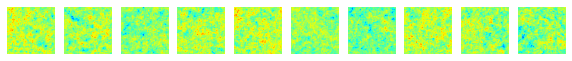

275/275 [==============================] - 5019s 18s/step - d_loss: -71.3931 - g_loss: 113.5080 - d_fake: 134.4020 - d_real: 36.9126 - g_root_mean_squared_error: 3.5835 - g_lsd: 11.2464 - g_extreme_rmse: 2.0115 - g_ws_weighted_rmse: 4.9354 - g_spatial_ks: 341.4325 - val_loss: -3.1417 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 9/100


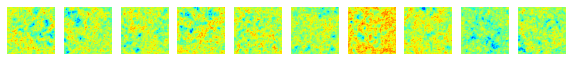

275/275 [==============================] - 5016s 18s/step - d_loss: -8.1142 - g_loss: -35.4326 - d_fake: -54.3616 - d_real: -57.5542 - g_root_mean_squared_error: 3.5758 - g_lsd: 11.2791 - g_extreme_rmse: 2.0167 - g_ws_weighted_rmse: 4.9427 - g_spatial_ks: 339.2374 - val_loss: 38.4704 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 10/100


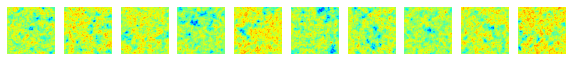

275/275 [==============================] - 5018s 18s/step - d_loss: -701.7008 - g_loss: 2074.8879 - d_fake: 70.3108 - d_real: -193.8772 - g_root_mean_squared_error: 3.5728 - g_lsd: 11.3020 - g_extreme_rmse: 2.0213 - g_ws_weighted_rmse: 4.9504 - g_spatial_ks: 337.6674 - val_loss: 9.8409 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 11/100


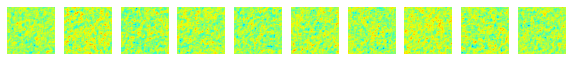

275/275 [==============================] - 5009s 18s/step - d_loss: -44.7076 - g_loss: -102.8823 - d_fake: -19.4003 - d_real: -29.4639 - g_root_mean_squared_error: 3.6028 - g_lsd: 11.3025 - g_extreme_rmse: 2.0358 - g_ws_weighted_rmse: 4.9640 - g_spatial_ks: 339.8745 - val_loss: -634.3872 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 12/100


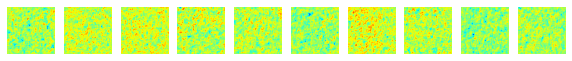

275/275 [==============================] - 5027s 18s/step - d_loss: -2654.5791 - g_loss: 6149.7482 - d_fake: -2455.2992 - d_real: -4401.2942 - g_root_mean_squared_error: 3.6180 - g_lsd: 11.3044 - g_extreme_rmse: 2.0466 - g_ws_weighted_rmse: 4.9756 - g_spatial_ks: 342.0992 - val_loss: 4820.7188 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 13/100


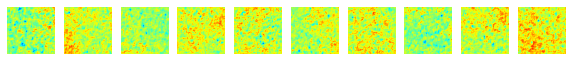

275/275 [==============================] - 5013s 18s/step - d_loss: -352.2903 - g_loss: 873.1967 - d_fake: 1314.9712 - d_real: 988.1778 - g_root_mean_squared_error: 3.6092 - g_lsd: 11.3311 - g_extreme_rmse: 2.0440 - g_ws_weighted_rmse: 4.9767 - g_spatial_ks: 343.3631 - val_loss: 4.1730 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 14/100


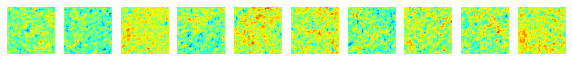

275/275 [==============================] - 5020s 18s/step - d_loss: -1357.2868 - g_loss: -7415.3793 - d_fake: -3298.3719 - d_real: -4203.6048 - g_root_mean_squared_error: 3.6028 - g_lsd: 11.3627 - g_extreme_rmse: 2.0403 - g_ws_weighted_rmse: 4.9715 - g_spatial_ks: 344.1717 - val_loss: -17199.1562 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 15/100


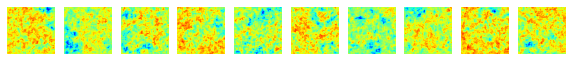

275/275 [==============================] - 5039s 18s/step - d_loss: -2406.1724 - g_loss: 9028.2718 - d_fake: 13638.7253 - d_real: 10411.6664 - g_root_mean_squared_error: 3.6014 - g_lsd: 11.4018 - g_extreme_rmse: 2.0365 - g_ws_weighted_rmse: 4.9614 - g_spatial_ks: 345.2030 - val_loss: -3567.1030 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 16/100


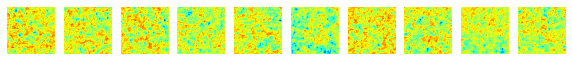

275/275 [==============================] - 5467s 20s/step - d_loss: -2534.4385 - g_loss: 4558.8555 - d_fake: 897.9719 - d_real: 258.0488 - g_root_mean_squared_error: 3.6050 - g_lsd: 11.4565 - g_extreme_rmse: 2.0365 - g_ws_weighted_rmse: 4.9622 - g_spatial_ks: 345.9895 - val_loss: -1285736.3750 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 17/100


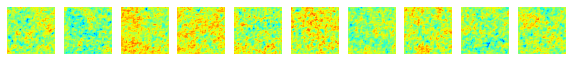

 30/275 [==>...........................] - ETA: 1:14:42 - d_loss: -4313.5365 - g_loss: 34633.0736 - d_fake: 36850.9139 - d_real: 25522.0222 - g_root_mean_squared_error: 3.6085 - g_lsd: 11.4802 - g_extreme_rmse: 2.0339 - g_ws_weighted_rmse: 4.9588 - g_spatial_ks: 346.5235

In [ ]:
gan.fit(inputs, outputs, callbacks=callbacks, epochs=100, batch_size=BATCH_SIZE, validation_split=0.25)

In [ ]:
for epoch in [6,8,12,35,40,50]:
    gan.load_weights(f'checkpoints/gan/weights-{epoch:02d}.ckpt')
    noise = FlexibleNoiseGenerator(noise_shape)()
    if not os.path.exists(f'plots/gan_pred/{epoch}'):
        os.mkdir(f'plots/gan_pred/{epoch}')
    for i in range(0, BATCH_SIZE*6, BATCH_SIZE):
        results = gan.generator.predict([inputs[i:i+BATCH_SIZE], noise])
        j=0
        for inp, out, res in zip(inputs[i:i+BATCH_SIZE], outputs[i:i+BATCH_SIZE], results):
            fig = show([inp, out, res])
            fig.savefig(f'plots/gan_pred/{epoch}/inp_{i}_batch_{j}.png')
            j+=1